In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
import diffusionstuff10 as ds
from copy import copy as dup
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

In [2]:
# Graphics parameters
%matplotlib notebook
ticklabelsize = 11
fontsize = 15
linewidth = 2

### The cell below specifies parameters for the 0-d and 1-d runs

<IPython.core.display.Javascript object>


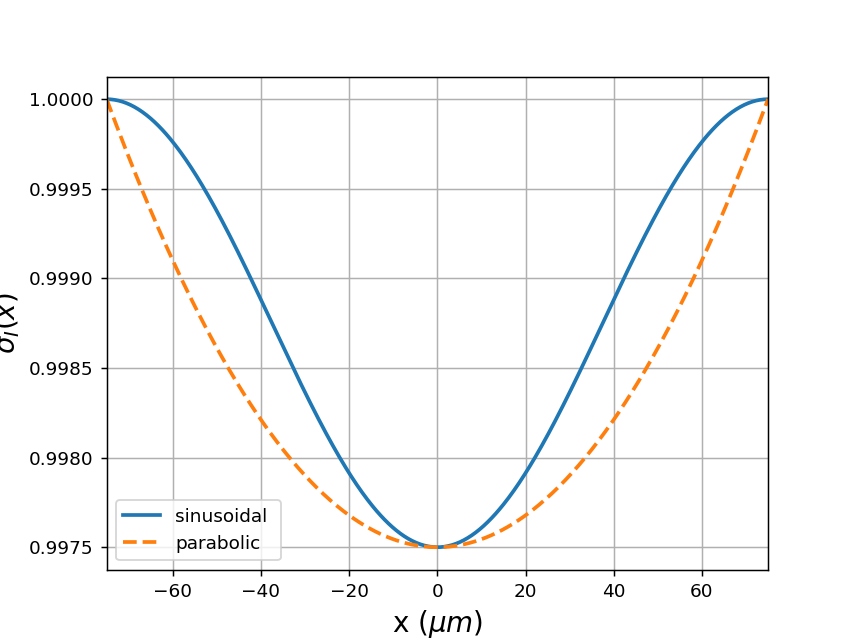

D = 0.002 um^2/us 2.0 x 10^-9 m^2/sec
deltat_max (Diffusion time) = 45.0
deltat = 90.0
nu_kin_mlyperus = 0.8333333333333334 monolayers/us
nmid = 250
N* = 0.1432394487827058
N*x2pi = 0.9
Nbar, Nbar-N*, N*/Nbar = 1.0 0.8567605512172942 0.1432394487827058
deltax = 0.3
sigma_0 = 0.19
sigmaIcorner = 0.21
center reduction = 0.25 %
c_r = 0.0025 dimensionless
max growth rate = 52.5 um/sec
min growth rate = 4.999999999999998 um/sec
nu_kin = 250 um/sec
dx = 0.3
L = 75.0 micrometers


In [3]:
#Setting up the system
nx = 501 # Number of points in simulation box
xmax = 150
x = np.linspace(0, xmax, nx)
boxpoints = len(x)
deltax = x[1]-x[0]
Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)
nmid = int(nx/2)
xmid = max(x)/2
xmax = x[nx-1]
L = xmax/2

# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
D = 2e-3 # micrometers^2/microsecond
# D = 1.6e-4 # micrometers^2/microsecond
# D = 2e-5 # micrometers^2/microsecond
# D = 8e-6 # micrometers^2/microsecond
# D = 2e-7 # micrometers^2/microsecond

# Time steps
dtmaxtimefactor = .5
dtmax = deltax**2/D
t_init = 0.0
deltat = dtmax/dtmaxtimefactor
tinterval = [t_init, t_init+deltat]

# Deposition rate
nu_kin = 34 # microns/second - about right for 240 K
nu_kin = 49 # microns/second - between 240 and 260 K
nu_kin = 250 # microns/second - about right for 260 K
nu_kin_mlyperus = nu_kin/umpersec_over_mlyperus # monolayers per microsecond

# Supersaturation
sigma0 = 0.19
sigmaIcorner = 0.20 # Must be bigger than sigma0 to get growth
sigmaIcorner = 0.21 # Must be bigger than sigma0 to get growth
center_reduction = 0.25 # In percent
c_r = center_reduction/100

# Diffusion coefficient scaled for this time step and space step
Doverdeltax2 = D/deltax**2

# Overlying supersaturation
sigmaI_sinusoid = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='sinusoid')
sigmaI_parabolic = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='parabolic')
# sigmaIstyle = 'sinusoid'
sigmaIstyle = 'parabolic'
if sigmaIstyle=='sinusoid':
    sigmaI = sigmaI_sinusoid
elif sigmaIstyle=='parabolic':
    sigmaI = sigmaI_parabolic
else:
    print('bad choice')
plt.figure()
plt.plot(x-xmid,sigmaI_sinusoid/sigmaIcorner, \
         x-xmid, sigmaI_parabolic/sigmaIcorner, '--',lw=linewidth)
plt.xlim([-xmid,xmid])
plt.legend(['sinusoidal ', 'parabolic'])
plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
plt.grid('on')

# 0D run parameters
uselayers = True
if uselayers:
    layermax_0D = 1000
else:
    countermax_0D = 100

# 1D run parameters
if uselayers:
    layermax_1D = 1000
else:
    countermax_1D = 15000

# Integrator
# odemethod ='Radau' # much too slow (implicit)
# odemethod ='BDF' # still slow (implicit), faster than Radau, results closest to DOP853 and LSODA
odemethod ='DOP853' # slowest of explicit methods
# odemethod ='LSODA' # results are a lot like DOP853, but faster
# odemethod ='RK45' # faster, but results look different from LSODA
# odemethod ='RK23' # fastest, produces V-shaped profiles

# Reporting
print("D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec')
print('deltat_max (Diffusion time) =', dtmax)
print('deltat =', deltat)
print('nu_kin_mlyperus =', nu_kin_mlyperus, 'monolayers/us')
print('nmid =', nmid)
print('N* =', Nstar)
print('N*x2pi =', Nstar*2*np.pi)
print('Nbar, Nbar-N*, N*/Nbar =', Nbar, Nbar-Nstar, Nstar/Nbar)
print('deltax =', deltax)
print('sigma_0 =', sigma0)
print('sigmaIcorner =', sigmaIcorner)
print('center reduction =', center_reduction, '%')
print('c_r =', c_r, 'dimensionless')
print('max growth rate =', nu_kin_mlyperus*sigmaIcorner*umpersec_over_mlyperus, 'um/sec')
print('min growth rate =', nu_kin_mlyperus*(sigmaIcorner-sigma0)*umpersec_over_mlyperus, 'um/sec')
print('nu_kin =', nu_kin, 'um/sec')
print('dx =', deltax)
print('L =', L, 'micrometers')

### This is the 0-d run

In [4]:
# Bundle parameters for ODE solver
params = [Nbar, Nstar, sigmaIcorner, sigma0, nu_kin_mlyperus]

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot_init_0D = 0

# Initialize the keeper arrays
tkeep_0D = []
ykeep_0D = []
tlast = t_init

# Call the ODE solver
ylast = np.array([Ntot_init_0D])
counter = 0
ttot = 0.0
while True:
    
    # Integrate up to next time step
    sol = solve_ivp(ds.f0d_solve_ivp_1var, tinterval, ylast, dense_output=True, args=(params,),rtol=1e-12,method=odemethod)

    ylast = sol.y[:,-1]
    tlast += deltat
    
    # Stuff into keeper arrays
    ykeep_0D.append(ylast)
    tkeep_0D.append(tlast)
    
    # Update counters and see whether to break
    Ntotlast = ylast
    counter += 1
    if uselayers:
        if Ntotlast > layermax_0D-1:
            break
    else:
        if counter > countermax_0D-1:
            break

In [5]:
# Convert results to a numpy array
ykeep_0D = np.array(ykeep_0D, np.float64)
Ntotkeep_0D = ykeep_0D[:,0]
NQLLkeep_0D = ds.getNQLL(Ntotkeep_0D,Nstar,Nbar)
tkeep_0Darr = np.array(tkeep_0D, np.float64)

0-D Modeled growth rate, um/s 14.149302724437538
0-D Modeled growth rate, ml/us 0.047164342414791796
0-D Modeled alpha 0.2695105280845245


<IPython.core.display.Javascript object>


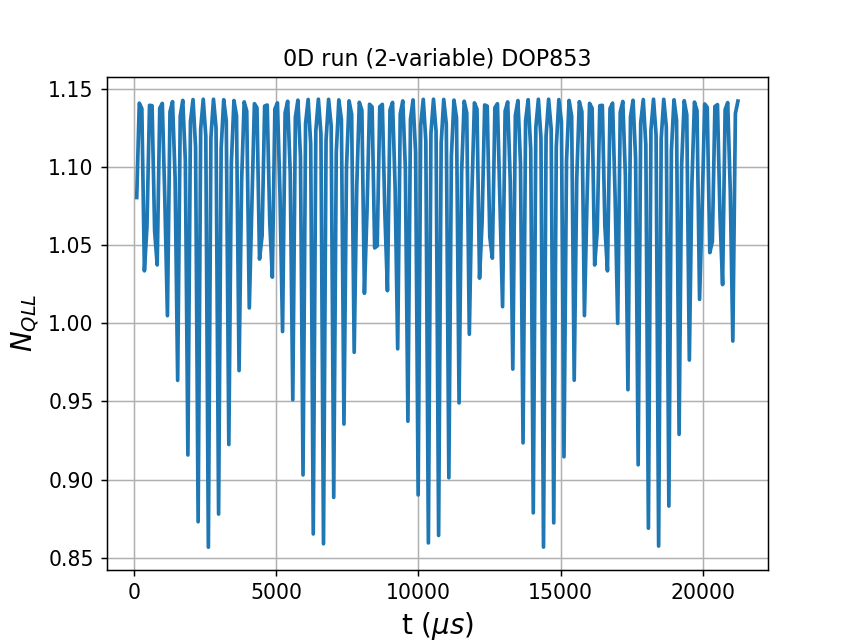

Text(0.5, 1.0, '0D run (2-variable) DOP853')

In [6]:
# Growth statistics
delta_Ntot_0D = Ntotkeep_0D[-1]-Ntot_init_0D
growthrate_0D_mlyperus = delta_Ntot_0D/tlast # monolayer/us
growthrate_0D = growthrate_0D_mlyperus*umpersec_over_mlyperus # um/sec
print( "0-D Modeled growth rate, um/s", growthrate_0D)
print( "0-D Modeled growth rate, ml/us", growthrate_0D_mlyperus)
alpha_0D = growthrate_0D/nu_kin/sigmaIcorner
print( "0-D Modeled alpha", alpha_0D)
title = '0D run (2-variable) '+odemethod

# Plot results
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,NQLLkeep_0D,lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')
plt.title(title)

### This is the 1-d run

In [7]:
# Bundle parameters for ODE solver
params = [Nbar, Nstar, sigmaI, sigma0, nu_kin_mlyperus, Doverdeltax2, nx] 

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot_init_1D = np.ones(nx)

# Initialize the keeper arrays
tkeep_1D = []
ykeep_1D = []
tlast = t_init

# Call the ODE solver
ylast = np.array(Ntot_init_1D)
print(np.shape(ylast))
counter = 0
layer = 0
ttot = 0.0
while True:
    # Integrate up to next time step
    sol = solve_ivp(ds.f1d_solve_ivp_1var, tinterval, ylast, args=(params,),rtol=1e-12,method=odemethod)
    ylast = sol.y[:,-1]
    tlast += deltat
        
    # Stuff into keeper arrays
    ykeep_1D.append(ylast)
    tkeep_1D.append(tlast)

    # Make some local copies
    ttot += deltat

    # Update counters and see whether to break
    Ntotlast = ylast
    minpoint = min(Ntotlast)
    maxpoint = max(Ntotlast)
    print(counter-1, int(Ntotlast[0]), maxpoint-minpoint)
    counter += 1
    if uselayers:
        if Ntotlast[0] > layermax_1D-1:
            break
    else:
        if counter > countermax_1D-1:
            break

(501,)
-1 5 0.076302724687479
0 9 0.04628137159128798
1 13 0.05838570402011989
2 17 0.16888030909561635
3 22 0.6851745277718315
4 26 0.44963252320770764
5 30 0.1688667891744835
6 34 0.2237734959376212
7 39 0.7778060030754972
8 43 0.8752664550763143
9 47 0.787222035166721
10 51 0.3952618314015339
11 56 0.8328317930064131
12 60 0.9592498925566559
13 64 0.980773985820548
14 68 1.0037015063821002
15 73 1.2072793671378292
16 77 1.0699697258470167
17 81 1.0582862208966333
18 85 1.1056153488696907
19 90 1.5653242361332502
20 94 1.6888598608878027
21 98 1.252018792250567
22 102 1.182036360835454
23 107 1.5737920519019042
24 111 1.8724346845156958
25 115 1.8699242407910504
26 119 1.6014966150153924
27 124 1.5965850247361857
28 128 1.942483413960062
29 132 1.9798745769666652
30 136 1.99793641446675
31 141 2.131384804467075
32 145 2.130453476854001
33 149 2.063979717820672
34 153 2.07622093643252
35 158 2.2412292411295027
36 162 2.728091412464721
37 166 2.499724272303439
38 170 2.187376854663256


In [8]:
# Convert results to a numpy array
ykeep_1D = np.array(ykeep_1D, np.float64)
Ntotkeep_1D = ykeep_1D
NQLLkeep_1D = ds.getNQLL(Ntotkeep_1D,Nstar,Nbar)
tkeep_1Darr = np.array(tkeep_1D, np.float64)

1-D growth rate, ml/us 0.04660647867825246
1-D growth rate, um/s 13.981943603475738
1-D alpha 0.2663227353042998
slowdown -1.18 %
Libbrecht's predicted growth rate 10.043193213321738 um/s
Libbrecht's predicted alpha 0.1912989183489855


<IPython.core.display.Javascript object>


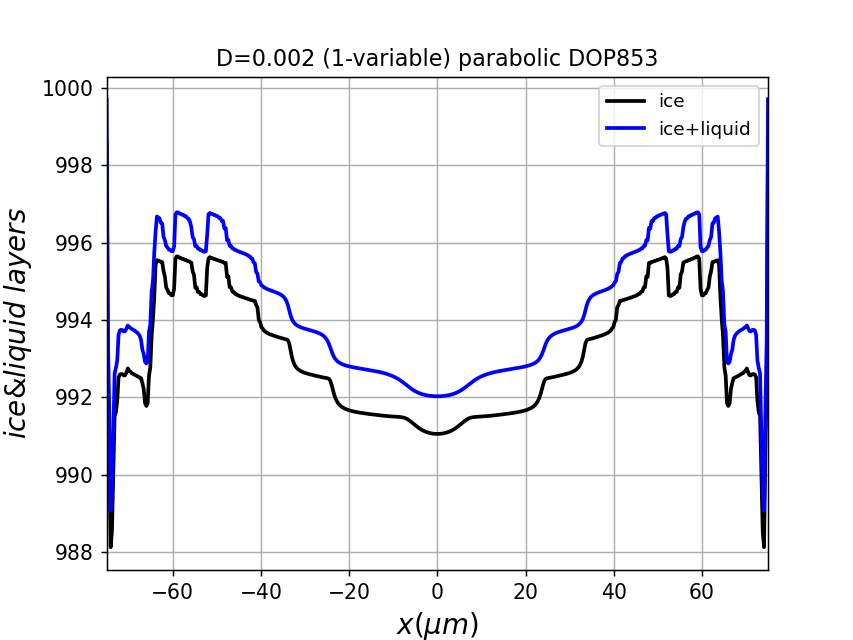

<IPython.core.display.Javascript object>


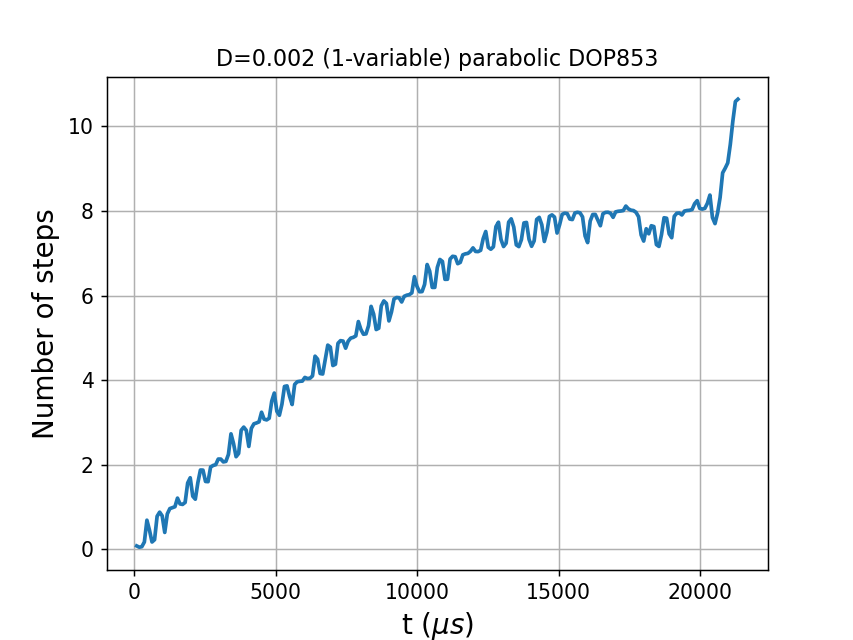

<IPython.core.display.Javascript object>


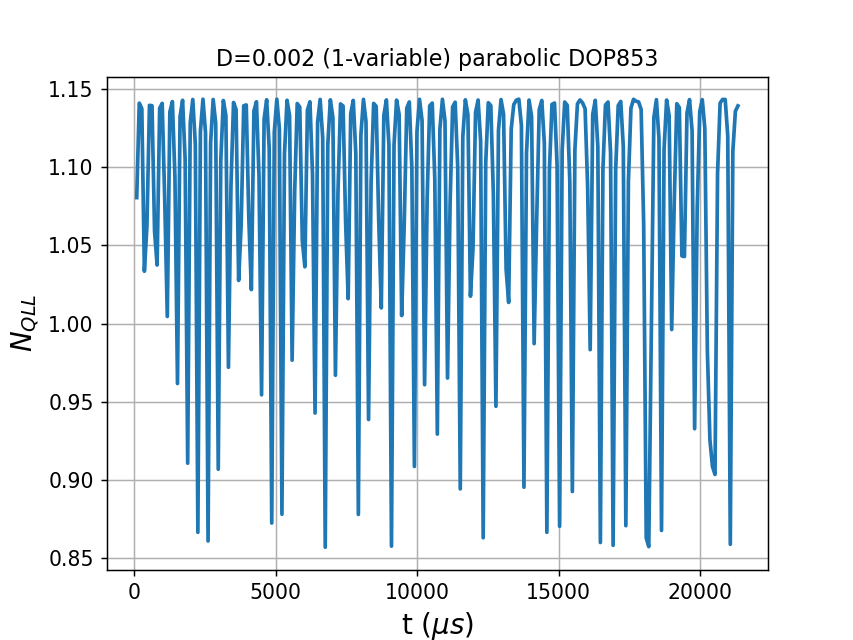

In [12]:
# Growth statistics
delta_Ntot_1D = Ntotkeep_1D[-1,0]-Ntotkeep_1D[0,0]
growthrate_1D_mlyperus = delta_Ntot_1D/tlast; print( "1-D growth rate, ml/us", growthrate_1D_mlyperus)
growthrate_1D = growthrate_1D_mlyperus*umpersec_over_mlyperus; print( "1-D growth rate, um/s", growthrate_1D)
alpha_1D = growthrate_1D/nu_kin/sigmaIcorner; print( "1-D alpha", alpha_1D)
slowdown = (alpha_1D-alpha_0D)/alpha_0D*100; print("slowdown", int(slowdown*100)/100,'%')
Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D
title = 'D='+str(D)+' (1-variable) '+sigmaIstyle+' '+odemethod

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmaIcorner)
print("Libbrecht's predicted growth rate", nu_kin*alpha_L*sigmaIcorner, "um/s")
print("Libbrecht's predicted alpha", alpha_L)

# Plot ice and liquid, last time step
plt.figure()
plt.plot(x-xmid, Nicekeep_1D[-1,:], 'k', label='ice', lw=linewidth)
plt.plot(x-xmid, Ntotkeep_1D[-1,:], 'b', label='ice+liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice & liquid \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot number of steps over time
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
plt.plot(tkeep_1D,f,lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel('Number of steps',fontsize=fontsize)
plt.title(title)
plt.grid('on')

# Plot QLL over time, at the corner
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_1D,NQLLkeep_1D[:,0],lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.title(title)
plt.grid('on')

### The cell below is just backup for parameters, and allows some exploration (but not part of the simulation)

In [10]:
# # The time required for an initial gaussian to diffuse
# layer_growth_rate = growthrate_0D/umpersec_over_mlyperus; print('Layer growth rate =', layer_growth_rate)
# t1 = 1/layer_growth_rate; print('Time_to_add_a_layer =', t1)
# t2 = 2.5**2/D; print('Time to diffuse across a terrace =', t2)
# t3 = 0.2**2/D; print('Time to diffuse into a step =', t3)
# t4 = 0.001; print('Time for ice-QLL equilibration =', t4)

# # How a change in the crystal size could be used to calculate a new diffusion coefficient with the same D/dx^2
# D_old = 2e-6
# D_new = D_old/50**2*100**2; print(D_new)

# # Computing the kinetic deposition velocity ... roughly, 260 
# import numpy as np
# M = 18 # g/mol
# T = 260 # K
# NA = 6.02e23
# m = M/NA; print(m,'mass of a molecule of water, grams/mol')
# m /= 1e3; print(m,'mass of a molecule of water, kg/mol')
# R = 8.314 # J/K-mol
# k = R/NA; print(k,"Boltzmann's constant, J/K")

# Pvap = 200 # Pascals (see https://byjus.com/clausius-clapeyron-equation-calculator/)
# V_gas = R*T/Pvap # Must be in m^3
# V_gas *= (10/1)**3; print(V_gas, 'Liters') 
# V_gas *= (10/1)**3; print(V_gas, 'cm^3') # see https://www.omnicalculator.com/physics/ideal-gas-law
# c_sat = 1/V_gas # mol/cm^3
# c_sat*=M; print(c_sat,'density of vapor, g/cm^3')

# c_solid = 0.92; print(c_solid, 'density of ice, g/cm^3')
# V_solid = 1/c_solid # cm^3/g

# V_ratio = V_gas/V_solid; print(V_ratio,'ratio of volumes')
# c_ratio = c_sat/c_solid; print(c_ratio,'ratio of densities')

# sqrtfactor = np.sqrt(k*T/(2*np.pi*m))
# nukin = c_sat/c_solid*sqrtfactor; print(nukin,'kinetic velocity, m/s')
# nukin *= 1e6; print(nukin, 'kinetic velocity, um/s')

# # Computing the kinetic deposition velocity ... roughly, 240 K has nukin of 40 um/s (we used 49 um/s in the paper)
# M = 18 # g/mol
# T = 240 # K
# NA = 6.02e23
# m = M/NA; print(m,'mass of a molecule of water, grams/mol')
# m /= 1e3; print(m,'mass of a molecule of water, kg/mol')
# R = 8.314 # J/K-mol
# k = R/NA; print(k,"Boltzmann's constant, J/K")

# Pvap = 26 # Pascals (see https://byjus.com/clausius-clapeyron-equation-calculator/)
# V_gas = R*T/Pvap # Must be in m^3
# V_gas *= (10/1)**3; print(V_gas, 'Liters') 
# V_gas *= (10/1)**3; print(V_gas, 'cm^3') # see https://www.omnicalculator.com/physics/ideal-gas-law
# c_sat = 1/V_gas # mol/cm^3
# c_sat*=M; print(c_sat,'density of vapor, g/cm^3')

# c_solid = 0.92; print(c_solid, 'density of ice, g/cm^3')
# V_solid = 1/c_solid # cm^3/g

# V_ratio = V_gas/V_solid; print(V_ratio,'ratio of volumes')
# c_ratio = c_sat/c_solid; print(c_ratio,'ratio of densities')

# sqrtfactor = np.sqrt(k*T/(2*np.pi*m))
# nukin = c_sat/c_solid*sqrtfactor; print(nukin,'kinetic velocity, m/s')
# nukin *= 1e6; print(nukin, 'kinetic velocity, um/s')

# # Gladich et al recommendation
# D_Gladich = 0.16e-9 # m^2/s
# D_Gladich *= (1e6/1)**2*(1/1e6); print('Gladich says, for 260 K, D = ', D_Gladich)